In [16]:
# url = 'https://github.com/leekyuyoung202306/PYTHON/raw/main/housing.tgz'
# import urllib.request as request
import pandas as pd
from pathlib import Path
import tarfile

In [17]:
# local_path = Path('/content/datasets/housing.tgz')
# def load_data_from_tgz():
#   if not local_path.is_file():
#     Path('datasets').mkdir(parents=True,exist_ok=True)
#     request.urlretrieve(url,local_path)
#     with tarfile.open(local_path) as f:
#       f.extractall(path='datasets')
# load_data_from_tgz()

In [18]:
!tar -xvzf './housing.tgz'

housing/
housing/housing.csv


In [19]:
housing = pd.read_csv('/content/housing/housing.csv')
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [20]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [21]:
import matplotlib.pyplot as plt
# 고해상도로  png 파일을 저장하기 위한 함수
IMAGE_PATH = Path() / 'images' / 'end_to_end_project'
IMAGE_PATH.mkdir(parents=True,exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extention='png',reslution=300):
  path = IMAGE_PATH / f"{fig_id}.{fig_extention}"
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path,format =fig_extention, dpi=reslution )

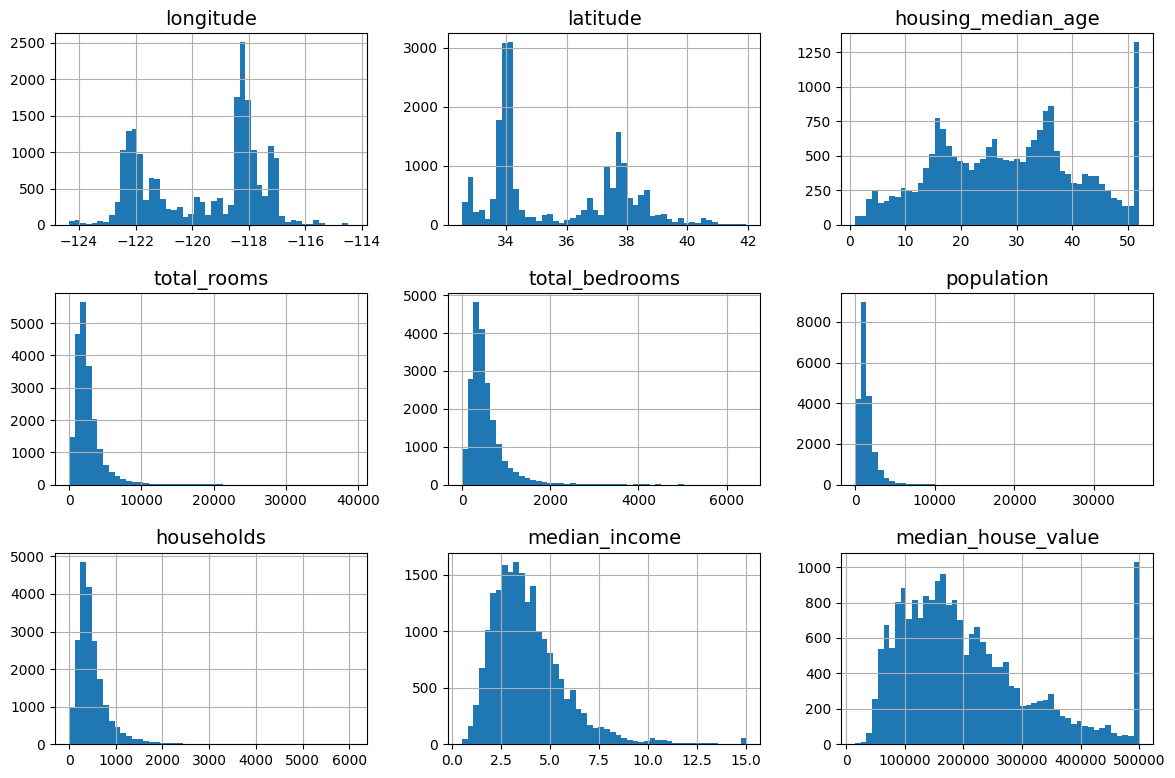

In [22]:
# 각 컬럼의 분포.. 히스토그램으로 데이터 의 분포를 확인
plt.rc('font', size=14)
plt.rc('axes', labelsize=14,titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12,8))
save_fig('attribute_historgram_plots')
plt.show()

In [23]:
# 테스트 세트 만들기
import numpy as np
def shuffle_and_split_data(data, test_ratio):
  shuffle_indices = np.random.permutation(len(data))
  test_set_size = int(len(data)*test_ratio)
  test_indices = shuffle_indices[:test_set_size]
  train_indeces = shuffle_indices[test_set_size:]
  return data.iloc[train_indeces], data.iloc[test_indices]

In [24]:
train_set, test_set = shuffle_and_split_data(housing,0.2)
train_set.shape, test_set.shape

((16512, 10), (4128, 10))

In [25]:
# 실행결과를 일정하게 유지 랜덤시드를 설정
np.random.seed(42)

In [26]:
# 무작위성 요소  set의 순서. 파이썬 시작시 랜덤하게 시드가 부여되는 hash()함수기반으로 동작합니다.
# (3.3부터 적용  Dos공격을 막기위해서)  PYTHONHASHSEED 환경변수 값을 0으로 설정
# 파이썬 시작후에 설정은 소용없지만. 코렙에서는 노트북을 실행하면 항상 이 변수가 설정

In [27]:
from zlib import crc32  # hash값을 생성하는 함수
def is_id_in_test_set(identifier, test_ratio):
  return crc32(np.int64(identifier)) < test_ratio*2**32  # 32비트 부동소수점과 비교
# 이 값보다 작으면 데이터가 테스트 집합으로 할당
def split_data_with_id_hash(data,test_ratio,id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_:is_id_in_test_set(id_,test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]
#   ~in_test_set : in_test_set을 만족하지 않는 데이터

In [28]:
housing_with_id = housing.reset_index()  # index열 추가
train_set, test_set =  split_data_with_id_hash(housing_with_id,0.2,'index')

In [29]:
housing_with_id['id'] = housing['longitude']*1000+housing['latitude']
train_set, test_set =  split_data_with_id_hash(housing_with_id,0.2,'id')

In [30]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing,test_size=0.2,random_state=42)

In [31]:
test_set['total_bedrooms'].isnull().sum()

44

In [32]:
# 인구의 여성비율이 51.1%일때 1000명으로 구성된 랜덤 샘플에서 여성이 48.5% 작거나 53.3%보다 많을 확률계산
# 이항분포를 사용   누적분포함수 : cdf() 메서드 --> 여성의 수가 주어진 값보다 작거나 같을 확률반환
from scipy.stats import binom
sample_size = 1000
ratio_female = 0.511
proba_too_small =  binom(sample_size,ratio_female).cdf(485-1)  # 484이하의 값이 나올 확률 계산
proba_too_large = 1- binom(sample_size,ratio_female).cdf(534)
print(proba_too_small + proba_too_large)

0.11534429488259296


In [33]:
housing['income_cat'] = pd.cut(
    housing['median_income'],
    bins=[0.,1.5,3.0,4.5,6.,np.inf],
    labels = [1,2,3,4,5]
)

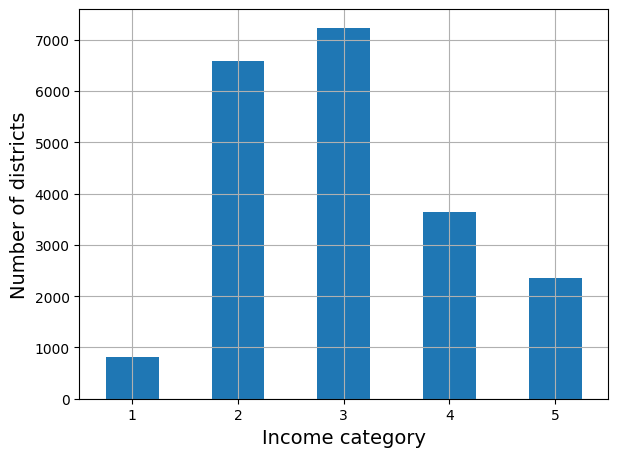

In [34]:
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0,grid=True)
plt.xlabel('Income category'); plt.ylabel('Number of districts')
save_fig('housing_income_cat_bar_plot')
plt.show()

In [35]:
# 데이터를 계층적 샘플링하여 훈련 집합과 테스트 집합을 만드는데 사용 클래스
# 클래스 레이블이 불균형할때 유용하게 사용 - 클래스간의 분포를 유지하면서 데이터를 분한
from sklearn.model_selection import StratifiedShuffleSplit

In [36]:
splitter = StratifiedShuffleSplit(n_splits =10, test_size=0.2,random_state=42)
strat_splits = []
for train_index,test_index in splitter.split(housing,housing['income_cat'] ):
  strat_train_set_n =  housing.iloc[train_index]
  strat_test_set_n =  housing.iloc[test_index]
  strat_splits.append([strat_train_set_n,strat_test_set_n])

In [37]:
strat_train_set, strat_test_set =  strat_splits[0]

In [38]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_cat, dtype: float64

In [39]:
# 탐색과 시각화
housing  = strat_train_set.copy()

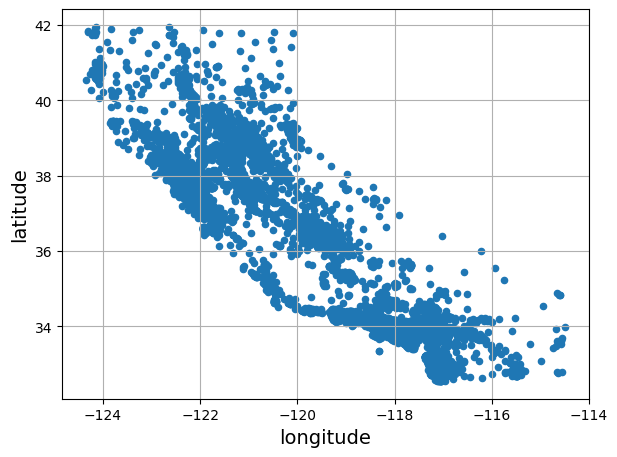

In [40]:
# 지리적 데이터 시각화
housing.plot(kind='scatter',x='longitude', y='latitude', grid=True)
save_fig('bad_visualization_plot')
plt.show()

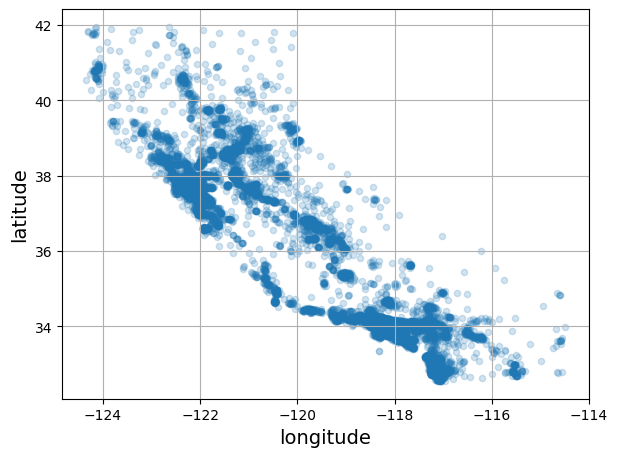

In [41]:
housing.plot(kind='scatter',x='longitude', y='latitude', grid=True, alpha=0.2)
save_fig('better_visualization_plot')
plt.show()

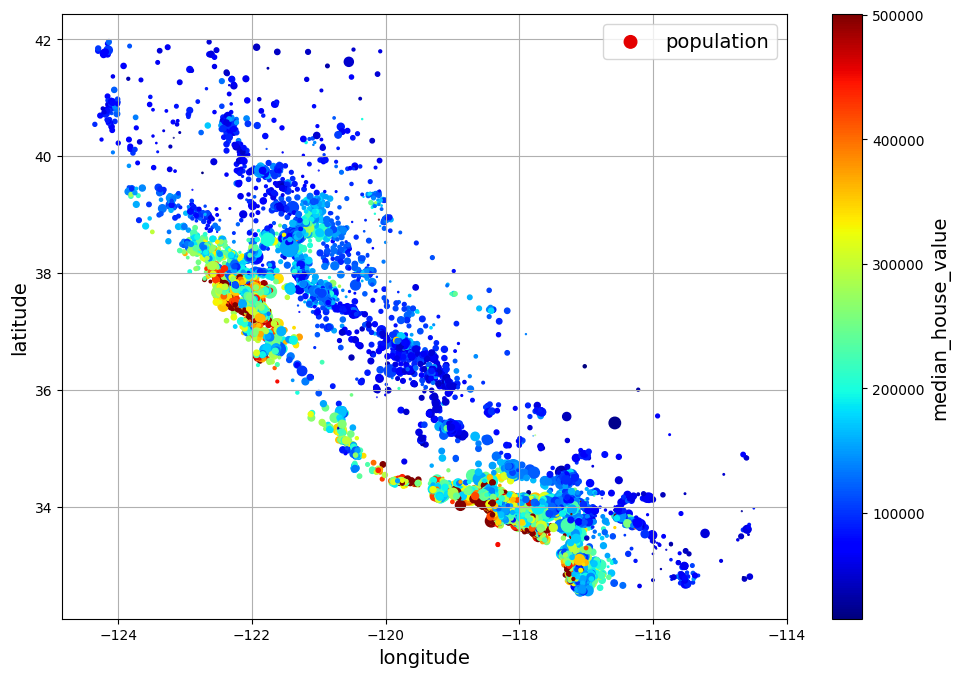

In [42]:
from matplotlib import legend
housing.plot(kind='scatter',x='longitude', y='latitude', grid=True,
             s = housing['population'] / 100, label = 'population',
             c = 'median_house_value', cmap='jet', colorbar = True,
             legend = True,figsize=(10,7),
            #  alpha=0.2
             )
save_fig('housing_prices_scatterplot')
plt.show()

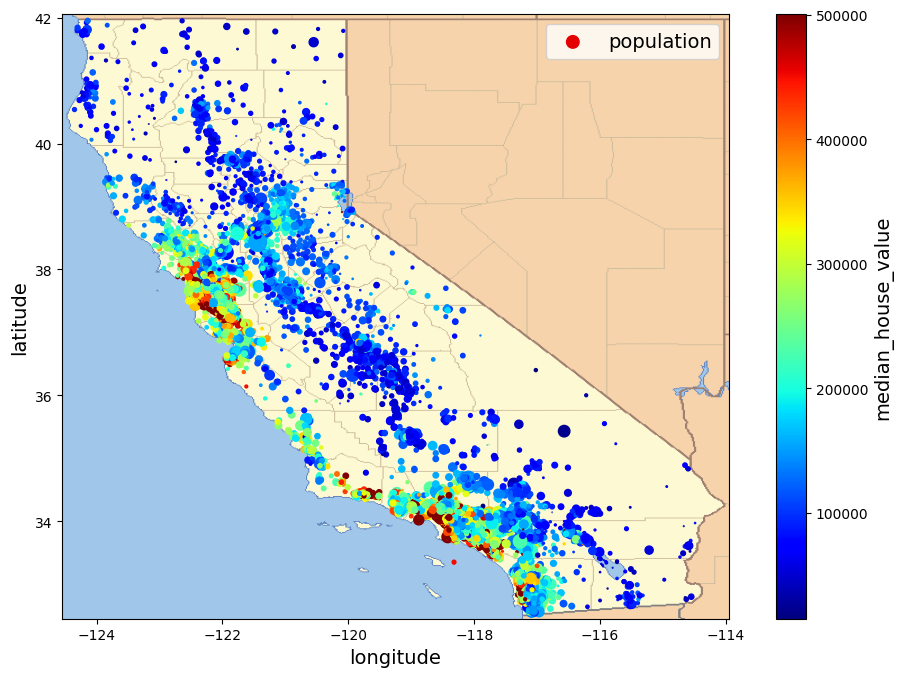

In [44]:
filename = '/content/california.png'
housing.plot(kind='scatter',x='longitude', y='latitude',
            #  grid=True,
             s = housing['population'] / 100, label = 'population',
             c = 'median_house_value', cmap='jet', colorbar = True,
             legend = True,figsize=(10,7),
            #  alpha=0.2
             )
california_img = plt.imread(filename)
axis = -124.55,-113.95,32.45,42.05   #지도에 위도와 경도 범위를 설정  이범위는 캘리포니아 지역
plt.axis(axis)  # 그래프의 축 범위를 제한
plt.imshow(california_img,extent=axis) # extent=axis 이미지의 위치를 조정
save_fig('california_housing_population_prices_plot')
plt.show()


In [45]:
# 상관관계 조사
# pandas 1.5 버전 부터는 수치형 데이터만 포함하는지 여부를 결정하는 numeric_only
corr_matrix = housing.corr(numeric_only=True)

In [46]:
temp = corr_matrix['median_house_value'].sort_values(ascending=False)
print(temp)
temp.index[:4]

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64


Index(['median_house_value', 'median_income', 'total_rooms',
       'housing_median_age'],
      dtype='object')

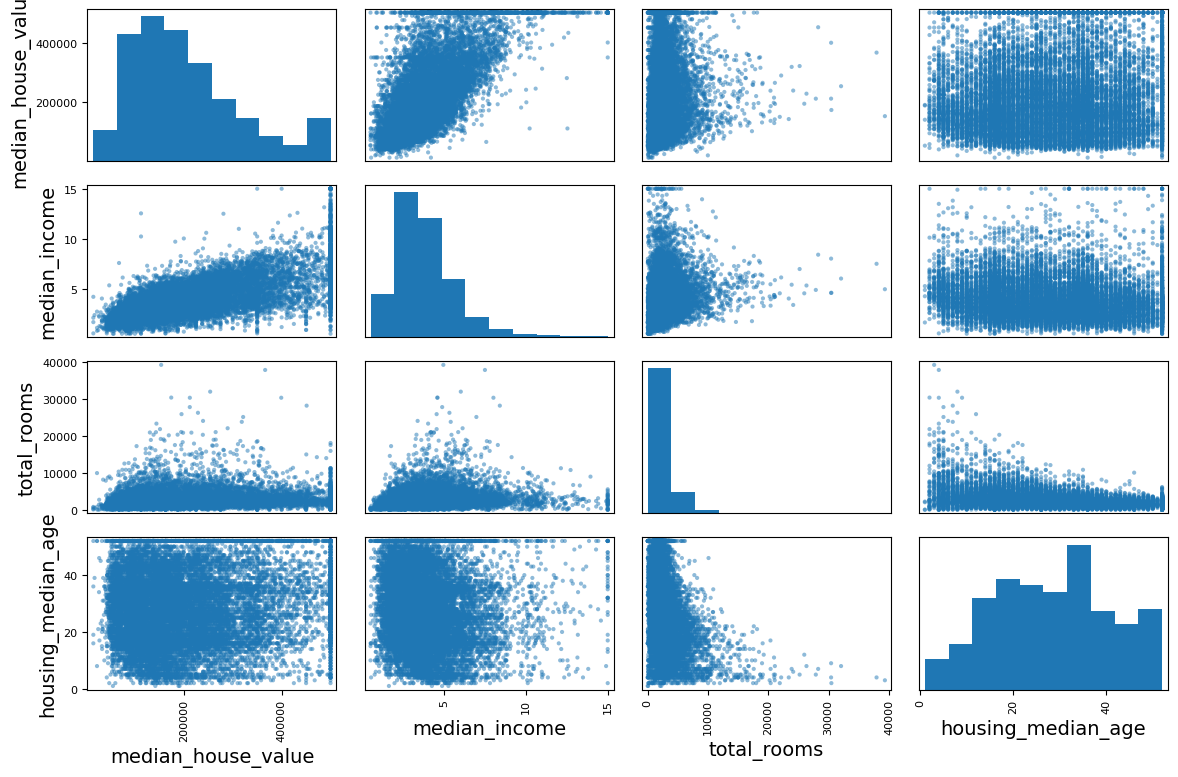

In [47]:
from pandas.plotting import scatter_matrix
attributes = list(temp.index[:4])
scatter_matrix(housing[attributes], figsize=(12,8))
save_fig("scatter_matrix_plot")
plt.show()

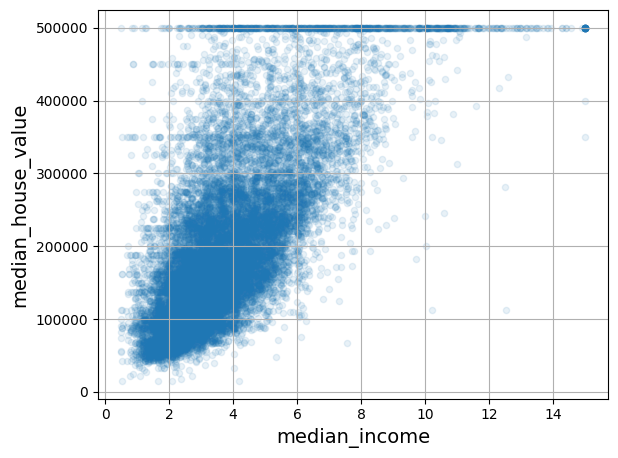

In [48]:
housing.plot(kind='scatter',x='median_income', y='median_house_value',alpha=0.1,grid=True)
save_fig('income_vs_house_value_scatterplot')
plt.show()

In [49]:
# 특성 조합으로 실험
housing['rooms_per_house'] = housing['total_rooms'] / housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_house'] = housing['population']  / housing['households']

In [50]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

In [51]:
# 머신러닝을 위한 데이터 준비
housing =  strat_train_set.drop('median_house_value',axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [52]:
null_rows_idx =  housing.isnull().any(axis=1)  # 결측치가 있는 row를 찾는다.
housing.loc[null_rows_idx].head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
14452    -120.67     40.50                15.0       5343.0             NaN   
18217    -117.96     34.03                35.0       2093.0             NaN   
11889    -118.05     34.04                33.0       1348.0             NaN   
20325    -118.88     34.17                15.0       4260.0             NaN   
14360    -117.87     33.62                 8.0       1266.0             NaN   

       population  households  median_income ocean_proximity income_cat  
14452      2503.0       902.0         3.5962          INLAND          3  
18217      1755.0       403.0         3.4115       <1H OCEAN          3  
11889      1098.0       257.0         4.2917       <1H OCEAN          3  
20325      1701.0       669.0         5.1033       <1H OCEAN          4  
14360       375.0       183.0         9.8020       <1H OCEAN          5

In [53]:
housing_option1 = housing.copy()
# housing_option1.dropna('total_bedrooms', axis=1)
# housing_option1.dropna(subset=['total_bedrooms'])

In [54]:
housing_option2 = housing.copy()
median = housing['total_bedrooms'].median()
housing_option2['total_bedrooms'].fillna(median,inplace=True)

In [55]:
# 사이킷런을 이용해서 결측치를 처리
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
housing_num =  housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,index = housing_num.index)
housing_tr[null_rows_idx]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
14452    -120.67     40.50                15.0       5343.0           434.0   
18217    -117.96     34.03                35.0       2093.0           434.0   
11889    -118.05     34.04                33.0       1348.0           434.0   
20325    -118.88     34.17                15.0       4260.0           434.0   
14360    -117.87     33.62                 8.0       1266.0           434.0   
...          ...       ...                 ...          ...             ...   
2348     -122.70     38.35                14.0       2313.0           434.0   
366      -122.50     37.75                44.0       1819.0           434.0   
18241    -121.44     38.54                39.0       2855.0           434.0   
18493    -116.21     33.75                22.0        894.0           434.0   
16519    -117.86     34.01                16.0       4632.0           434.0   

       population  households  median_income  
14452      2503.0       902.0         3.5962  
18217      1755.0       403.0         3.4115  
11889      1098.0       257.0         4.2917  
20325      1701.0       669.0         5.1033  
14360       375.0       183.0         9.8020  
...           ...         ...            ...  
2348        954.0       397.0         3.7813  
366        1137.0       354.0         3.4919  
18241      1217.0       562.0         3.2404  
18493       830.0       202.0         3.0673  
16519      3038.0       727.0         5.1762  

[168 rows x 8 columns]

In [56]:
# 이상치
from sklearn.ensemble import IsolationForest
isolation_forest =  IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)
# 이상치는 -1  정상은 1

In [57]:
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

In [58]:
# 이상치를 삭제하고 싶다
# housing =  housing.iloc[outlier_pred == 1]
# housing_labels = housing_labels.iloc[outlier_pred == 1]

텍스트와 범주형 데이터 다루기

In [111]:
# 범주형 데이터 ocean_proximity 전처리
housing_cat =  housing[['ocean_proximity']]
housing_cat.head(8)

ocean_proximity
13096        NEAR BAY
14973       <1H OCEAN
3785           INLAND
14689          INLAND
20507      NEAR OCEAN
1286           INLAND
18078       <1H OCEAN
4396         NEAR BAY

In [113]:
# 순서형(ordinal) 데이터 / 명목형(nominal) 데이터
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder =  OrdinalEncoder()
housing_cat_encoded =  ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [115]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [117]:
# one hot encoding
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [118]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [121]:
df_test = pd.DataFrame({'ocean_proximity':['ISLAND','NEAR BAY']})
pd.get_dummies(df_test)

ocean_proximity_ISLAND  ocean_proximity_NEAR BAY
0                       1                         0
1                       0                         1

In [128]:
cat_encoder.transform(df_test).toarray()

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [130]:
df_test_unknown = pd.DataFrame({"ocean_proximity" : ['<1H OCEAN','ISLAND']})
pd.get_dummies(df_test_unknown)

ocean_proximity_<1H OCEAN  ocean_proximity_ISLAND
0                          1                       0
1                          0                       1

In [132]:
cat_encoder.handle_unknown = 'ignore'
cat_encoder.transform(df_test_unknown).toarray()

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [133]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [134]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [137]:
cat_encoder.transform(df_test_unknown).toarray()

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [138]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown).toarray(),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index )
df_output

ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  ocean_proximity_ISLAND  \
0                        1.0                     0.0                     0.0   
1                        0.0                     0.0                     1.0   

   ocean_proximity_NEAR BAY  ocean_proximity_NEAR OCEAN  
0                       0.0                         0.0  
1                       0.0                         0.0

In [139]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [140]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

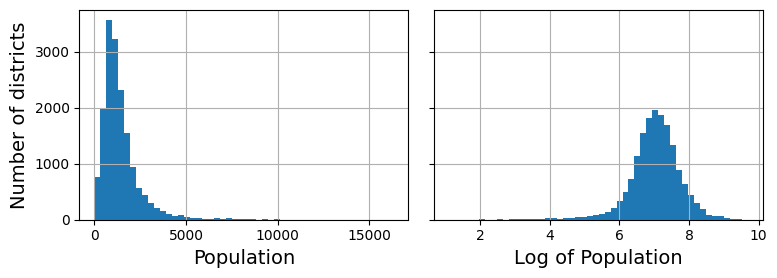

In [145]:
# 로그변환을 하는 이유
# 데이터분포의 왜곡 보정 : 데이터가 치우쳐진경우 왜곡을 줄여준다. 특히 분산이 크거나 꼬리 부분이 긴 경우
# 선형 관계강화 : 몇몇의 경우, 로그변환을 하면 데이터간의 관계를 선형으로 만들어줄수 있다
# 스케일 조정 : 데이터를 적절한 범위로 압축, 모델이 일부 변수에 과도하게 영향을 받는것을 방지

fig,axs =  plt.subplots(1,2,figsize=(8,3), sharey=True)
housing['population'].hist(ax = axs[0],bins=50)
housing['population'].apply(np.log).hist(ax = axs[1],bins=50)  # 데이터 분포가 한쪽으로 치우져져 있거나 꼬리가 긴 경우에 유용
axs[0].set_xlabel('Population')
axs[1].set_xlabel('Log of Population')
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

In [151]:
#rbf 커널 라이브러리  : Radial Basis Function(RBF) 커눌을 사용 두 개의 데이터 포인트간의 유사도를 계산
# SVM 머신의 알고리즘에 사용
from sklearn.metrics.pairwise import rbf_kernel
age_simil_35 =  rbf_kernel(housing[['housing_median_age']], [[35]], gamma = 0.1)

지도 시각화

In [59]:
!pip install folium

In [60]:
import folium

In [84]:
# 35.23678400,139.11684800
m = folium.Map(location=['37.5','127'],
              #  tiles="cartodb positron",
               zoom_start=12,
               width=750,
               height=500
              )

In [85]:
folium.Marker(
    location=['37.5','127'],
    tooltip="Click me!",
    popup="서초구",
    icon=folium.Icon(icon="cloud"),
).add_to(m)

In [86]:
m

In [87]:
# 주소를 위경로 변환

In [88]:
# curl -v -X GET "https://dapi.kakao.com/v2/local/search/address.json" \
#   -H "Authorization: KakaoAK ${REST_API_KEY}" \
#   --data-urlencode "query=전북 삼성동 100"

In [102]:
import requests
# Rest API는  requests.get()을 이용해서  url주소 요청하면.. 서버에서 response응답 객체를 받는다
REST_API_KEY = "92adac142332ceaba7167c6c0d20262d"
base_url = "https://dapi.kakao.com/v2/local/search/address.json";
headers = {"Authorization" : f"KakaoAK {REST_API_KEY}"}
params = {"query":"서울시 용산구 소월로 323"}
response =  requests.get(base_url, headers=headers,params=params)
if response.status_code == 200:
  data = response.json()
  x,y = data['documents'][0]['x'], data['documents'][0]['y']

In [103]:
x,y

('126.996940925194', '37.5415755386499')

In [106]:
m = folium.Map(location=['37.5','127'],
              #  tiles="cartodb positron",
               zoom_start=12,
               width=750,
               height=500
              )

folium.Marker(
    location=['37.5415755386499','126.996940925194'],
    tooltip="서울시 용산구 소월로 323",
    popup="",
    icon=folium.Icon(icon="cloud"),
).add_to(m)

In [107]:
m